In [1]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict
import common.layers as layers
from dataset.mnist import load_mnist
from common.trainer import Trainer

In [2]:


class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param_1={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 conv_param_2={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):

        conv_output_size_1 = (input_dim[1] - conv_param_1['filter_size'] + 2 * conv_param_1['pad']) // conv_param_1['stride'] + 1
        pool_output_size_1 = conv_param_1['filter_num'] * (conv_output_size_1 // 2) * (conv_output_size_1 // 2)

        conv_output_size_2 = (conv_output_size_1 // 2 - conv_param_2['filter_size'] + 2 * conv_param_2['pad']) // conv_param_2['stride'] + 1
        pool_output_size_2 = conv_param_2['filter_num'] * (conv_output_size_2 // 2) * (conv_output_size_2 // 2)

        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size'])
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = weight_init_std * np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size'])
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])
        self.params['W3'] = weight_init_std * np.random.randn(pool_output_size_2, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Conv2'] = layers.Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Pool2'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W4'], self.params['b4'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):
        self.loss(x, t)

        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W3'], grads['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W4'], grads['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 200

network = SimpleConvNet(input_dim=(1, 28, 28), 
                        conv_param_1={'filter_num': 32, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        conv_param_2={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

train loss:2.3022151152325603
=== epoch:1, train acc:0.15, test acc:0.165 ===
train loss:2.302107622990834
train loss:2.3017812623408886
train loss:2.30120119910658
train loss:2.2991989866184444
train loss:2.299185391573182
train loss:2.300468163183612
train loss:2.294832822556624
train loss:2.2854324805075836
train loss:2.2899497078458055
train loss:2.2795715799065044
train loss:2.2598632852377687
train loss:2.2354939266041636
train loss:2.259156102094678
train loss:2.250414594946545
train loss:2.2135402542830223
train loss:2.232769257157855
train loss:2.1825717220815886
train loss:2.1336944098233017
train loss:2.154958637079398
train loss:2.091854638391038
train loss:2.0502534558450964
train loss:2.0042190724128135
train loss:1.8878867680786886
train loss:1.765723185998919
train loss:1.8155329041256305
train loss:1.7121366446847701
train loss:1.5991175765019068
train loss:1.4299711440023914
train loss:1.4377024573225992
train loss:1.3419615619723007
train loss:1.368436509624166
train

In [4]:
network.save_params("params_self.pkl")
print("Saved Network Parameters!")


Saved Network Parameters!


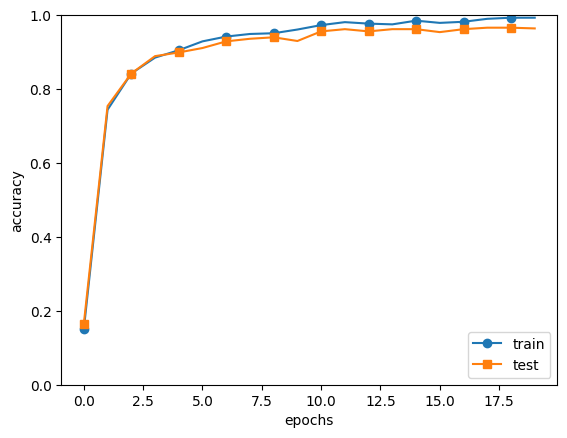

In [5]:

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()